In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

We are going to minimize the function
\begin{align}
    \mathcal{G}(\mu) = \mathcal{E}_F(\mu) + \int\log(\mu(x))d\mu(x).
\end{align}
If we define
$$
F(x) = 0.5|x|^2
$$
and
$$
H(\mu) = \int\log(\mu(x))d\mu(x)
$$
then note that we are going to minimize $\mathcal{G}$ which is merely an integral over a quadratic function according to the measure $\mu$, regularized by negative entropy. We want to find the measure that minimizes this value. In our case specifically, this minimization amounts to minimizing the KL divergence, i.e., $\mathcal{G}(\mu)$ is the KL divergence between $\mu$ and $\mu_*$ where $\mu_*$ is standard Gaussian distribution. The idea is that we want to iteratively update the measure $\mu_n$ according to the proximal-gradient update scheme
\begin{align}
    \nu_{n+1} &= (I - \gamma\nabla F)_{\#}\mu_n\\
    \mu_{n+1} &\in \mathrm{JKO}_{\gamma H}(\nu_{n+1}).
\end{align}
The idea is that as $n\to\infty$, we have that $\mu_n \to \mu_*$. The authors give convergence guarantees and convergence rates which we're not going to look at here. But, in our specific example, we know that this update scheme is equivalent to
\begin{align}
    m_{k+1} &= m + (I-\gamma\Sigma^{-1})(m_k - m)\\
    \Sigma_{k+1}(I - \gamma\Sigma_{k+1}^{-1})^2 &= \Sigma_k (I-\gamma\Sigma^{-1})^2,
\end{align}
where $m$ represents the mean and $\Sigma$ represents the variance (covariance matrix specifically of the iterative distribution). We may use this update structure directly on the mean and variance since every iterative distributional update $\mu_n$ is Gaussian necessarily and because we have a closed form for the $\mathrm{JKO}$ operator. So, in our example, we resort to 1D optimal transport through these iterative updates (which we may perform specifically on just the mean and variance through these updates), we have $m_* = 0$ and $\sigma_* = 1$, and initialize with $m_0 = 10$ and $\sigma_0 = 100$. At every step, we also have a closed form expression for the Wasserstein-2 distance $W^2 (\mu_n, \mu_*) = m_{n}^2 + (1 - \sqrt{\sigma_n})^2$. We now code all of this up.

How would we get the covariance matrix at the next time step.

$$
\Sigma_{k+1}(I - \gamma\Sigma_{k+1}^{-1})^2 = \Sigma_k (I-\gamma\Sigma^{-1})^2 \Rightarrow \Sigma_{k+1}^2 - (2\gamma I +  \Sigma_k (I-\gamma\Sigma^{-1})^2 )\Sigma_{k+1} + \gamma^2 I = 0.
$$
Now call $A = 2\gamma I +  \Sigma_k (I-\gamma\Sigma^{-1})^2 $, then it comes down to solving 
$$
 \Sigma_{k+1}^2 - A\Sigma_{k+1} + \gamma^2 I = 0.
$$
Say we want to find the elements of $\Sigma_{k+1}$, this then becomes a nonlinear root finding problem with possibly multiple solutions. Therefore, I'm going to throw Newton's method at it with initial guess $\Sigma$ (the thing we want to go to) and pray to god. The equations I want to find the root of, are
$$
\begin{cases}
a^2 + bc - (A_{11} a+ A_{12} c) + \gamma^2 = 0,\\
b(a+d) - (A_{11} b+ A_{12} d) = 0,\\
c(a+d) - (A_{21} a+ A_{22} c) = 0,\\
d^2 + bc - (A_{21} b + A_{22} d) + \gamma^2 = 0.
\end{cases}
$$

Note that the Jacobian is given by
$$
J = \begin{bmatrix}
2a-A_{11} & c & b- A_{12} & 0\\
b & a+d-A_{11} & 0 & b-A_{12}\\
c-A_{21} & 0 & a+d-A_{22} & c\\
0 & c-A_{21} & b & 2d-A_{22}
\end{bmatrix}.
$$
Let's implement that.

In [2]:
normal = lambda x,m,s: (1/(np.sqrt(2*np.pi*s**2)))*(np.exp(-0.5*(x-m)**2/(s**2)))

In [3]:
def f(x,g,A):
    a, b, c, d = x
    f1 =  a ** 2 + b*c - (A[0][0] * a + A[0][1] * c) + g**2
    f2 =  b*(a+d) - (A[0][0] * b + A[0][1] * d)
    f3 =  c*(a+d) - (A[1][0] * a + A[1][1] * c)
    f4 =  d ** 2 + b*c - (A[1][0] * b + A[1][1] * d) + g**2
    return np.array([f1,f2,f3,f4])

In [4]:
def df(x,A):
        a, b, c, d = x
        return np.array([
            [2*a - A[0, 0], c, b - A[0, 1], 0],
            [b, a + d - A[0, 0], 0, b - A[0, 1]],
            [c - A[1, 0], 0, a + d - A[1, 1], c],
            [0, c - A[1, 0], b, 2*d - A[1, 1]]
        ])

In [5]:
def Newton_meth(S0,A,g, tol=1e-10, max_iter=1000):
    
    x = np.array([S0[0,0],S0[0,1],S0[1,0],S0[1,1]])
    for i in range(max_iter):
        fx = f(x,g,A)
        if np.linalg.norm(fx) < tol:
            return np.array([[x[0],x[1]],[x[2],x[3]]])

        dfx = df(x,A)
        dx = np.linalg.solve(dfx, -fx)
        x = x + dx

        if np.linalg.norm(dx) < tol * (1 + np.linalg.norm(x)):
            return np.array([[x[0],x[1]],[x[2],x[3]]])
        
    return np.array([[x[0],x[1]],[x[2],x[3]]])
    
    
    

In [6]:
def ff(x,A,g):
    a, b, c, d = x
    f1 =  a ** 2 + b*c - (A[0][0] * a + A[0][1] * c) + g**2
    f2 =  b*(a+d) - (A[0][0] * b + A[0][1] * d)
    f3 =  c*(a+d) - (A[1][0] * a + A[1][1] * c)
    f4 =  d ** 2 + b*c - (A[1][0] * b + A[1][1] * d) + g**2
    return np.array([f1,f2,f3,f4])

In [7]:
def fff(x,A,g,I):
    X = np.array([[x[0],x[1]],[x[2],x[3]]])
    f = X @ X - A @ X + g**2 *  I
    return np.array([f1,f2,f3,f4])

In [8]:
A = np.array([[1, 2], [3, 4]])
gamma = 0
initial_guess = np.array([[1, 1],[ 1, 1]])
root = Newton_meth(initial_guess, A, gamma)
print("Root:", root)

Root: [[-1.18614066 -1.18614066]
 [ 0.81385934  0.81385934]]


In [9]:
def Generate_random_points(n,mean,cov):
    points = []
    for i in range(n):
        random_vars = np.random.multivariate_normal(mean, cov)
        points.append(random_vars)
    return np.array(points)

In [10]:
# Example usage:
n = 5000  # Number of random points
mean = [1, 2]  # Mean of the distribution
cov = [[1, 0.5], [0.5, 2]]  # Covariance matrix of the distribution
random_points = Generate_random_points(n, mean, cov)

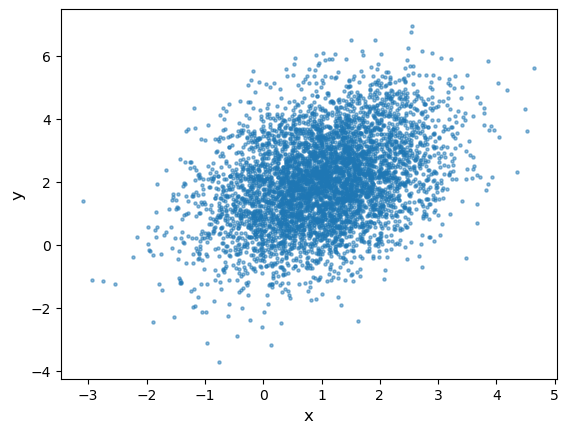

In [11]:
plt.scatter(random_points[:,0], random_points[:,1], s=5, alpha=0.5)
plt.ylabel("y",fontsize = 'large')
plt.xlabel("x",fontsize = 'large')
plt.show()

In [12]:
# Initialize model parameters (mean and variance) according to explanation above; also parameters of distribution we're trying to match
m0 = np.array([0,0])
s0 = np.array([[1, 0], [0, 1]])  # Covariance matrix of the distribution

m = np.array([10,3])
s = np.array([[1, 0], [0, 2]])
inv_s = np.array([[s[1,1]/(s[0,0]*s[1,1]-s[0,1]*s[1,0]), -s[0,1]/(s[0,0]*s[1,1]-s[0,1]*s[1,0])], [-s[1,0]/(s[0,0]*s[1,1]-s[0,1]*s[1,0]), s[0,0]/(s[0,0]*s[1,1]-s[0,1]*s[1,0])]])
gamma = 0.1 # -> This is just the "step size" in the proximal step
d = 5000 # how many particles we have at each step


sl,sv = np.linalg.eig(np.transpose(s)@s)

# Create lamda function of Wasserstein-2 distance
Wass = lambda mi,si: np.sum((m-mi)**2) +  (np.max(sl) - si)**2

# Initializing arrays that will keep updates of means and variances
n = 500
ms = []
ss = []
Ws = np.zeros(n+1)
Ws_bound = np.zeros(n+1)
particles = Generate_random_points(d, m0, s0)
init_particles = particles.copy()
mi = m0
si = s0

sl0,sv0 = np.linalg.eig(np.transpose(s0)@s0)
Ws[0] = Wass(m0,np.max(sl0))
Ws_bound[0] = Wass(m0,np.max(sl0))

I = np.eye(2)
plt.scatter(particles[:,0],particles[:,1], s=5, alpha=0.5, label = "MvG")
plt.scatter(init_particles[:,0],init_particles[:,1], s=5, alpha=0.5, label = "stdG")

plt.xlim(-3,14)
plt.ylim(-6,7)
plt.legend()
plt.ylabel("y",fontsize = 'large')
plt.xlabel("x",fontsize = 'large')
plt.savefig(f'images/{0:003}', dpi = 100, facecolor = 'white')
plt.close()
for i in range(1,n+1):
    # First, we compute the iterative update for the mean
    mi = mi - gamma * (inv_s @ (mi-m))
    ms.append(mi)
    
    A = 2*gamma*I+ si @ ((I - gamma * inv_s) ** 2)
    
    si = Newton_meth(si, A, gamma)
    
    #S = np.array([si[0,0],si[0,1],si[1,0],si[1,1]])
    #gg = lambda x: ff(x,A,gamma)
    #SI = scipy.optimize.root(gg,S)
    #si = np.array([[SI.x[0],SI.x[1]],[SI.x[2],SI.x[3]]])
    #si = s
    inv_si = np.array([[si[1,1]/(si[0,0]*si[1,1]-si[0,1]*si[1,0]), -si[0,1]/(si[0,0]*si[1,1]-si[0,1]*si[1,0])], [-si[1,0]/(si[0,0]*si[1,1]-si[0,1]*si[1,0]), si[0,0]/(si[0,0]*si[1,1]-si[0,1]*si[1,0])]])

    
    ss.append(si)
    
    sli,svi = np.linalg.eig(np.transpose(si)@si)
    
    Ws[i] = Wass(mi,np.max(sli))
    Ws_bound[i] += (1-gamma)*Ws_bound[i-1]
    
    for i1 in range(d):
        x = particles[i1,:]
        xhalf = x - gamma * (inv_s @ (x-m))
        particles[i1,:] = mi + np.linalg.solve(I-gamma * inv_si,xhalf-mi)
    
    plt.scatter(particles[:,0],particles[:,1], s=5, alpha=0.5, label = "MvG")
    plt.scatter(init_particles[:,0],init_particles[:,1], s=5, alpha=0.5, label = "stdG")
    plt.xlim(-3,14)
    plt.ylim(-6,7)
    plt.legend()
    plt.ylabel("y position",fontsize = 'large')
    plt.xlabel("x position",fontsize = 'large')
    plt.savefig(f'images/{i:003}', dpi = 100, facecolor = 'white')
    plt.close()
    
    # I use matlab to make the gif since I hate python

In [13]:
si

array([[1., 0.],
       [0., 2.]])

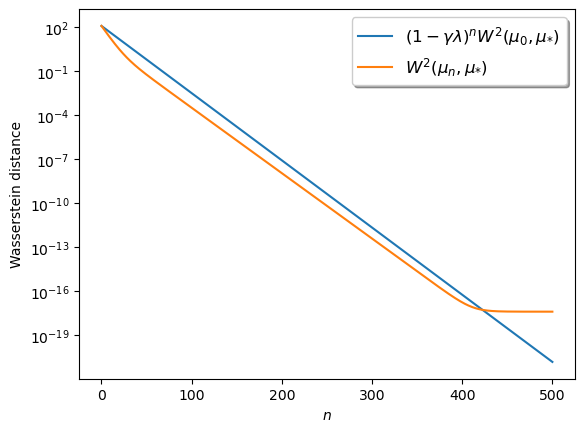

In [14]:
bound = plt.plot(Ws_bound, label = '$(1-\gamma\lambda)^{n}W^2(\mu_0,\mu_{*})$')
Err = plt.plot(Ws, label = '$W^2(\mu_n,\mu_{*})$')

legend = plt.legend(loc = 1, shadow = True, fontsize = 'large')
plt.ylabel('Wasserstein distance')
plt.xlabel('$n$')
plt.yscale('log')
plt.savefig('Wass_2D.png')

plt.show()

In [15]:
Ws

array([1.18000000e+02, 9.69881544e+01, 7.97614920e+01, 6.56353366e+01,
       5.40491256e+01, 4.45437499e+01, 3.67431290e+01, 3.03391819e+01,
       2.50795436e+01, 2.07575087e+01, 1.72037912e+01, 1.42797682e+01,
       1.18719392e+01, 9.88738203e+00, 8.25002589e+00, 6.89759642e+00,
       5.77911151e+00, 4.85282972e+00, 4.08456989e+00, 3.44633544e+00,
       2.91518851e+00, 2.47232870e+00, 2.10233972e+00, 1.79257332e+00,
       1.53264562e+00, 1.31402550e+00, 1.12969815e+00, 9.73890154e-01,
       8.41844849e-01, 7.29638702e-01, 6.34031267e-01, 5.52342530e-01,
       4.82352623e-01, 4.22219806e-01, 3.70413364e-01, 3.25658683e-01,
       2.86892272e-01, 2.53224907e-01, 2.23911408e-01, 1.98325843e-01,
       1.75941156e-01, 1.56312422e-01, 1.39063070e-01, 1.23873526e-01,
       1.10471843e-01, 9.86259644e-02, 8.81373216e-02, 7.88355242e-02,
       7.05739556e-02, 6.32261083e-02, 5.66825293e-02, 5.08482699e-02,
       4.56407497e-02, 4.09879659e-02, 3.68269866e-02, 3.31026803e-02,
      

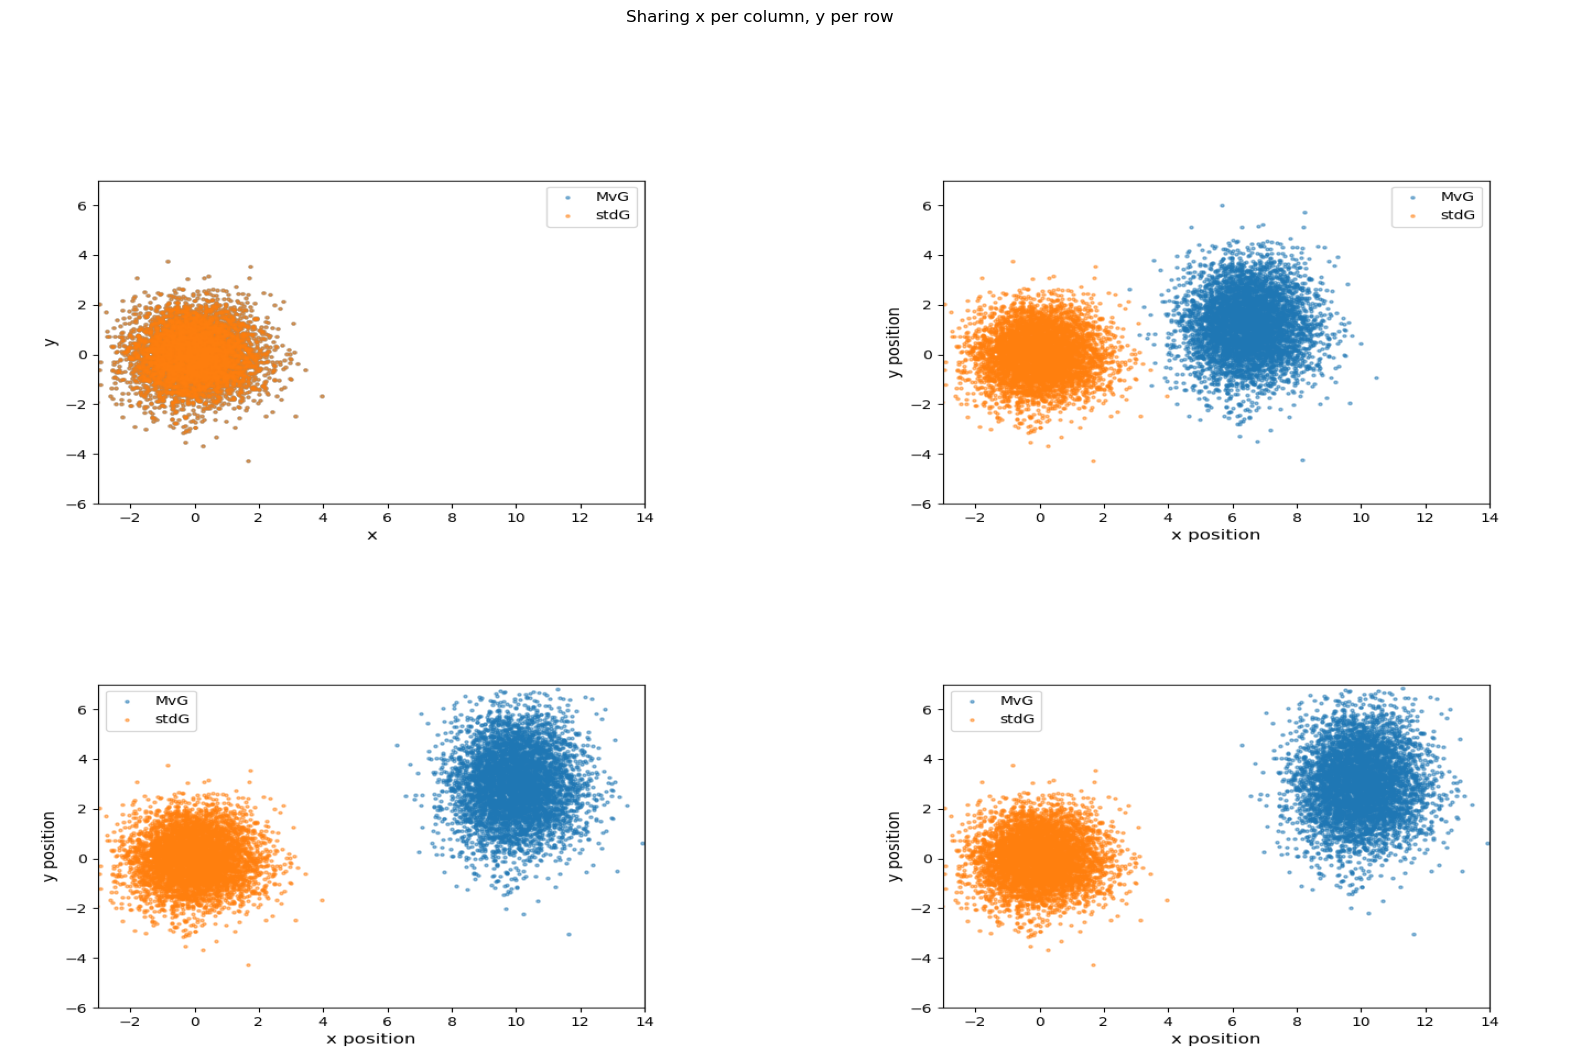

In [16]:
from PIL import Image
img1 = np.asarray(Image.open('images/000.png'))
img2 = np.asarray(Image.open('images/010.png'))
img3 = np.asarray(Image.open('images/100.png'))
img4 = np.asarray(Image.open('images/500.png'))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,12))
fig.suptitle('Sharing x per column, y per row')
ax1.imshow(img1, aspect='auto')
ax1.axis('off') 
ax2.imshow(img2, aspect='auto')
ax2.axis('off') 
ax3.imshow(img3, aspect='auto')
ax3.axis('off') 
ax4.imshow(img4, aspect='auto')
ax4.axis('off') 
for ax in fig.get_axes():
    ax.label_outer()
plt.savefig("combined_pic_2D.png")